# Experiment 2: Unstable Confounder

In this experiment, we use a simplified causal graph consisting of three nodes: immune state, sex, and AIRR (same as Experiment 1). Here we change the distribution of the confounder between the training and test, and show how it influences the prediction performance.

The set up is the same as in Experiment 1, except we change the p value in the binomial distribution of the confounder between training and test.

Immune state is a binary variable and can have values `True` or `False` to indicate if an individual is diseased or healthy. Confounder (sex) also in this setting has two values. AIRR is a set of sequences simulated based on the values of the immune state and the confounder for the given individual.

Steps:

1. Simulate training and test dataset from a causal graph to include: confounder (sex, implemented by creating repertoires with different OLGA models), immune state (implemented by implanting a signal in the repertoire)

2. Train an ML model (here: logistic regression on repertoires represented by the k-mer frequencies) on the train set and assess its performance on the test set in the presence of confounder where the confounder distribution changes between training and test.

Software used: 

- DagSim for simulation of the causal graph; 
- immuneML v2.1 for implanting signal in AIRRs and for training and assessing machine learning classifiers; 
- OLGA for simulation of naive AIRRs

## Step 1: AIRR simulation from a causal graph

In [1]:
import os
import yaml
import dagsim.baseDS as ds
import numpy as np
from pathlib import Path
from util.repertoire_util import make_olga_repertoire, load_iml_repertoire, make_AIRR_dataset, make_dataset
from util.implanting import make_immune_signal, make_repertoire_without_signal, make_repertoire_with_signal
from immuneML.util.PathBuilder import PathBuilder
from immuneML.simulation.implants.Signal import Signal

In [2]:
# remove results from the previous run

import shutil

if Path("./experiment2/").is_dir():
    shutil.rmtree("./experiment2/")

In [3]:
result_path = PathBuilder.build("./experiment2/data/")

train_example_count = 200
test_example_count = 50

# immune state: two binomial distributions depending on the confounder value with probability of success p
immune_state_p_conf0 = 0.3 # for confounder = 0
immune_state_p_conf1 = 0.5 # for confounder = 1

# confounder: binomial distribution with probability of success p
confounder_p_train = 0.5
confounder_p_test = 0.25

# other parameters
repertoire_implanting_rate = 0.01 # percentage of repertoire sequences to include immune state signal
sequence_count = 2000 # number of sequences in one repertoire

In [4]:
# define functions to create immune state, confounder, and AIRR

def get_immune_state(confounder: bool, p_conf0: float, p_conf1: float) -> bool:
    return np.random.binomial(n=1, p=p_conf1) if confounder else np.random.binomial(n=1, p=p_conf0)
    
def get_confounder(p) -> bool:
    return np.random.binomial(n=1, p=p)

def get_repertoire(immune_state: bool, confounder: bool, confounder_name: str, path: Path, sequence_count: int, signal: Signal, seed: int, repertoire_implanting_rate: float) -> str:
        
    PathBuilder.build(path)    

    # make olga repertoire by using one of two Olga models based on confounder value
    naive_repertoire = make_olga_repertoire(confounder=confounder, confounder_name=confounder_name, path=path, sequence_count=sequence_count, seed=seed)
    
    # implant a signal in the repertoire based on the immune state
    if immune_state:
        repertoire = make_repertoire_with_signal(repertoire=naive_repertoire, signal=signal, result_path=path / "immuneML_with_signal/", repertoire_implanting_rate=repertoire_implanting_rate)
    else:
        repertoire = make_repertoire_without_signal(repertoire=naive_repertoire, signal_name=signal.id, result_path=path / "immuneML_with_signal/")

    return repertoire.data_filename
    

In [5]:
# define the immune signal that will represent the immune state

signal = make_immune_signal()

# define nodes of the causal graph

index_node = ds.Generic(name="index", function=np.arange, size_field="stop")

confounder_node = ds.Generic(name="sex", function=get_confounder, arguments={"p": confounder_p_train})

immune_state_node = ds.Generic(name="immune_state", function=get_immune_state, 
                               arguments={"confounder": confounder_node, "p_conf0": immune_state_p_conf0,
                                         "p_conf1": immune_state_p_conf1})

repertoire_node = ds.Generic(name="repertoire", function=get_repertoire, 
                             arguments={"immune_state": immune_state_node, "confounder": confounder_node, "confounder_name": confounder_node.name,
                                        "path": result_path / "train", "sequence_count": sequence_count, "signal": signal, 
                                        "seed": index_node, 'repertoire_implanting_rate': repertoire_implanting_rate})


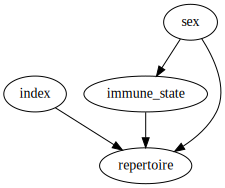

In [6]:
# make a causal graph using DagSim and show it graphically

graph = ds.Graph(name="graph_experiment_2", list_nodes=[index_node, confounder_node, immune_state_node, repertoire_node])
graph.draw()

In [7]:
# simulate a dataset using the graph

study_cohort_data = graph.simulate(num_samples=train_example_count, csv_name=str(result_path / "train/study_cohort"))


In [8]:
# make an AIRR dataset from the generated repertoires to be used for training

repertoires = [load_iml_repertoire(filepath=filepath) for filepath in study_cohort_data["repertoire"]]

train_dataset = make_dataset(repertoires=repertoires, path=result_path / 'train', dataset_name="experiment2_train", 
                             signal_names=[signal.id, confounder_node.name])

In [9]:
# make a test dataset

repertoire_node.additional_parameters['path'] = result_path / 'test' # update result_path: to be removed with DagSim update
confounder_node.additional_parameters['p'] = confounder_p_test # update the confounder distribution parameter for test

test_data = graph.simulate(num_samples=test_example_count, csv_name=str(result_path / "test/test_cohort"))

test_repertoires = [load_iml_repertoire(filepath=filepath) for filepath in test_data["repertoire"]]

test_dataset = make_dataset(repertoires=test_repertoires, path=result_path / 'test', 
                            dataset_name="experiment2_test", signal_names=[signal.id, confounder_node.name])


In [10]:
# merge datasets (but the distinction between train and test will be kept)

dataset = make_AIRR_dataset(train_dataset, test_dataset, result_path / 'full_dataset')

## Step 2: train an ML model and assess performance

In [11]:
specs = {
    "definitions": {
        "datasets": {
            "dataset1": {
                "format": 'AIRR',
                "params": {
                    "path": str(result_path / 'full_dataset'),
                    "metadata_file": str(result_path / 'full_dataset/metadata.csv')
                }
            }
        },
        "encodings": {
            "kmer_frequency": {
                "KmerFrequency": {"k": 3}
            }
        },
        "ml_methods": {
            "logistic_regression": {
                "LogisticRegression": {
                    "penalty": "l1",
                    "C": [0.01, 0.1, 1, 10, 100],
                },
                "model_selection_cv": True,
                "model_selection_n_folds": 5
            }
        },
        "reports": {
            "training_performance": { # report that will allow for comparison of train/test performance
                "TrainingPerformance": {
                    "metrics": ["log_loss", "balanced_accuracy", "auc"]
                }
            },
            "motif_recovery": { # to check how much coefficients overlap with the immune state signal that was implanted
                "MotifSeedRecovery": {
                    "implanted_motifs_per_label": {
                        "immune_state": {
                            "seeds": ["ADR", "ATS"],
                            "hamming_distance": True,
                            "gap_sizes": [0] # no gaps
                        }
                    }
                }
            },
            "coefficients": {
                "Coefficients": { # show top 25 logistic regression coefficients and what k-mers they correspond to
                    "coefs_to_plot": ['n_largest'],
                    "n_largest": [25]
                }
            },
            "feature_comparison": {
                "FeatureComparison": {
                    "comparison_label": "immune_state",
#                     "color_grouping_label": "sex",
                    "show_error_bar": False
                }
            }
        }
    },
    "instructions": {
        'train_ml': {
            "type": "TrainMLModel",
            "assessment": { # ensure here that train and test dataset are fixed, as per simulation
                "split_strategy": "manual",
                "split_count": 1,
                "manual_config": {
                    "train_metadata_path": str(result_path / "train/experiment2_train_metadata.csv"),
                    "test_metadata_path": str(result_path / "test/experiment2_test_metadata.csv")
                },
                "reports": {
                    "models": ["training_performance", "coefficients", "motif_recovery"],
                    "encoding": ["feature_comparison"]
                }
            },
            "selection": {
                "split_strategy": "random",
                "train_percentage": 0.7,
                "split_count": 1,
                "reports": {
                    "models": ["training_performance", "coefficients", "motif_recovery"],
                    "encoding": ["feature_comparison"]
                }
            },
            "settings": [
                {"encoding": "kmer_frequency", "ml_method": "logistic_regression"}
            ],
            "dataset": "dataset1",
            "refit_optimal_model": False,
            "labels": ["immune_state"],
            "optimization_metric": "log_loss",
            "metrics": ['balanced_accuracy', 'auc']
        }
    }
}

ml_result_path = PathBuilder.build("./experiment2/ml_result/")
specification_path = ml_result_path / "specs.yaml"

with open(specification_path, "w") as file:
    yaml.dump(specs, file)

In [12]:
# run immuneML with the specs file

output_path = ml_result_path / "result/"

os.system(f"immune-ml {specification_path} {output_path}")


2021-11-07 15:02:19.997253: Setting temporary cache path to experiment2/ml_result/result/cache
2021-11-07 15:02:19.997295: ImmuneML: parsing the specification...

2021-11-07 15:02:59.797700: Full specification is available at experiment2/ml_result/result/full_specs.yaml.

2021-11-07 15:02:59.797785: ImmuneML: starting the analysis...

2021-11-07 15:02:59.797823: Instruction 1/1 has started.
2021-11-07 15:02:59.861258: Training ML model: running outer CV loop: started split 1/1.

2021-11-07 15:02:59.903602: Hyperparameter optimization: running the inner loop of nested CV: selection for label immune_state (label 1 / 1).

2021-11-07 15:02:59.904352: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-11-07 15:02:59.904616: Encoding started...
2021-11-07 15:03:17.419863: Encoding finished.
2021-11-07 15:03:17.420177: ML model training started...
2021-11-07 15:04:10.428516: ML model training finished.
2021-11-07 15:04:16.698070: Encoding started...


2021-11-07 15:04:27.018896: Encoding finished.
2021-11-07 15:04:31.529363: Completed hyperparameter setting kmer_frequency_logistic_regression.

2021-11-07 15:04:31.530196: Hyperparameter optimization: running the inner loop of nested CV: completed selection for label immune_state (label 1 / 1).

2021-11-07 15:04:31.530224: Training ML model: running the inner loop of nested CV: retrain models for label immune_state (label 1 / 1).

2021-11-07 15:04:31.530712: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-11-07 15:04:31.530930: Encoding started...


2021-11-07 15:04:46.430855: Encoding finished.
2021-11-07 15:04:46.431116: ML model training started...
2021-11-07 15:05:52.381983: ML model training finished.
2021-11-07 15:05:59.666515: Encoding started...
2021-11-07 15:06:09.166310: Encoding finished.
2021-11-07 15:06:13.448657: Completed hyperparameter setting kmer_frequency_logistic_regression.

2021-11-07 15:06:13.449818: Training ML model: running the inner loop of nested CV: completed retraining models for label immune_state (label 1 / 1).

2021-11-07 15:06:13.449877: Training ML model: running outer CV loop: finished split 1/1.

Performances (log_loss) -----------------------------------------------


Label: immune_state
Performance (log_loss) per assessment split:
Split 1: 0.4768340410363062
Average performance (log_loss): 0.4768340410363062
------------------------------
2021-11-07 15:06:13.907678: Instruction 1/1 has finished.
2021-11-07 15:06:13.916343: Generating HTML reports...
2021-11-07 15:06:14.238850: HTML reports ar

/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which 

0